## Building a Large Language Model (From Scratch) Chapter 6: Fine-tuning for Classification

Las dos formas mas comunes de fine-tunear un LLM son "Instruction Fine-tuning" y "Classification Fine-tuning"

Ejemplos de Instruction Fine-tuning:

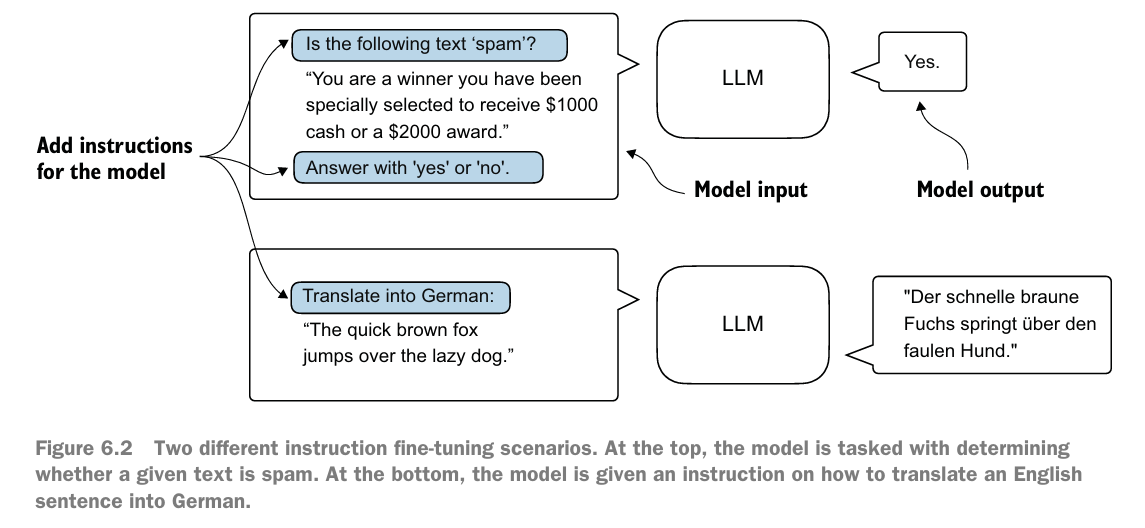

Ejemplos de Classification Fine-tuning:

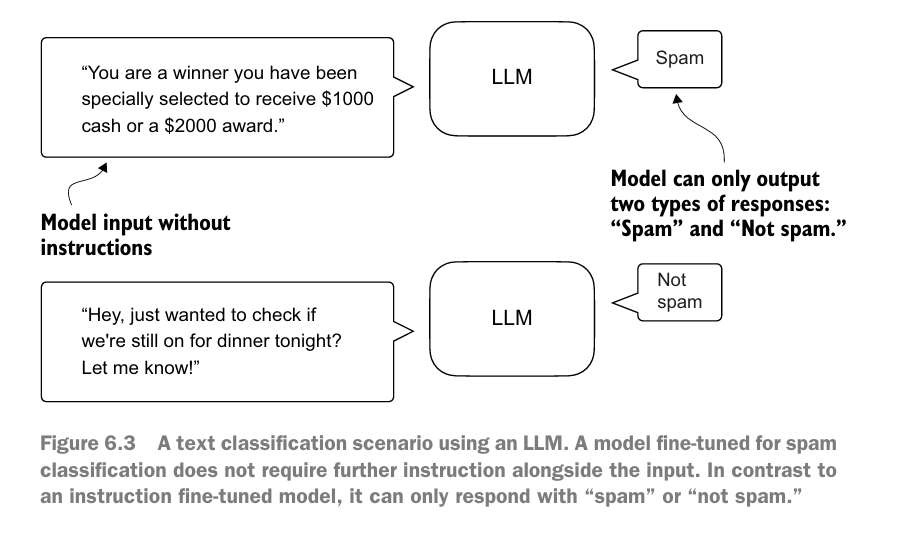

Pasos a seguir:

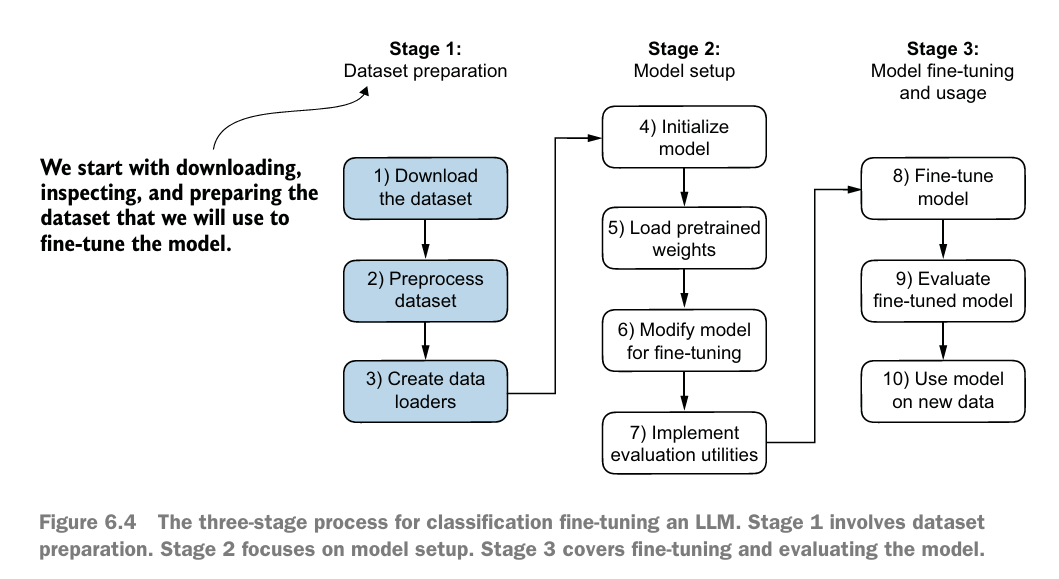

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
      "and extraction."
 )
        return
    with urllib.request.urlopen(url) as response:   
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:   
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)              
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


In [4]:
%pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.5 MB 11.2 MB/s eta 0:00:01
   ----------- ---------------------------- 3.4/11.5 MB 8.4 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.5 MB 8.2 MB/s eta 0:00:01
   --------------------------- ------------ 7.9/11.5 MB 9.5 MB/s eta 0:00:01
   ---------------------------------- ----- 10.0/11.5 MB 9.7 MB/s eta 0:00:01
   ---------------------------------------  11.3/11.5 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 11.5/11.5 MB 8.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

df = pd.read_csv(
data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df 

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [6]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Creamos un dataset balanceado y sampleamos 747 instancias de "ham"

In [7]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]    
    ham_subset = df[df["Label"] == "ham"].sample(
    num_spam, random_state=123
    )                                        
    balanced_df = pd.concat([
 ham_subset, df[df["Label"] == "spam"]
    ])                              
    return balanced_df
balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [8]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

Hacemos un split de 70% training, 10% validación y 20% testing

In [10]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(
frac=1, random_state=123
    ).reset_index(drop=True)              
    train_end = int(len(df) * train_frac)         
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]
    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1)

Guardamos todo en .csv para usar después

In [11]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

### Creando los data loaders

Antes trabajabamos con una sliding window que hacía que cada instancia tuviera una longitud fija. Ahora tenemos instancias de longitud variante.

Vamos a hacer padding en las instancias así podemos hacer que todas tengan la misma longitud.

In [12]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


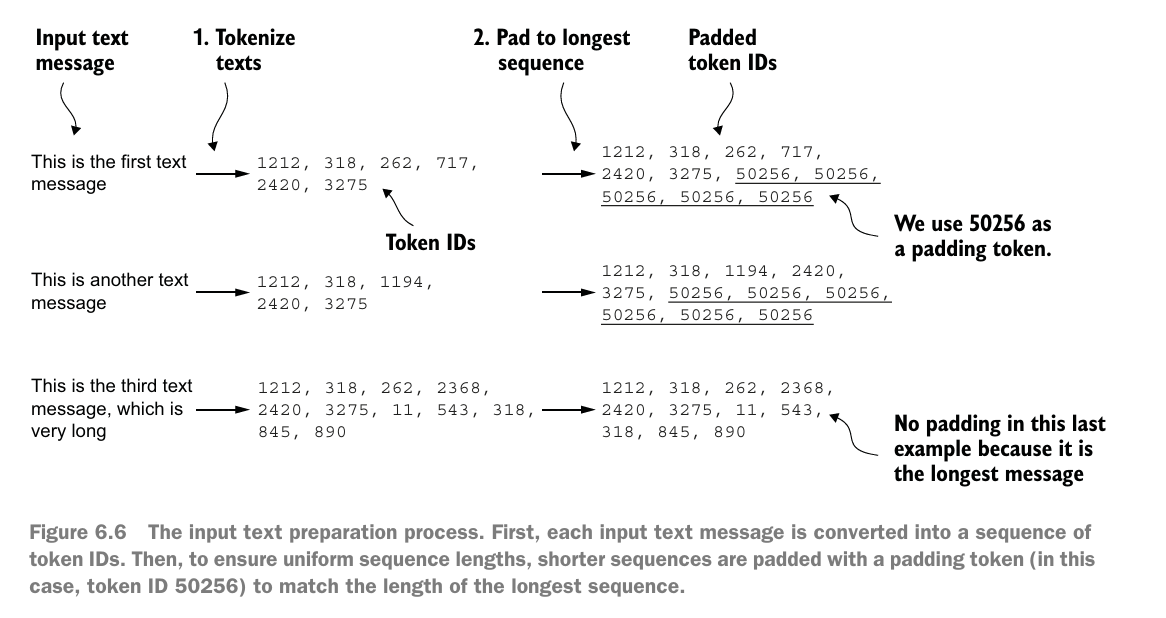

In [15]:
import torch
from torch.utils.data import Dataset
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
         pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
        tokenizer.encode(text) for text in self.data["Text"]
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]
        self.encoded_texts = [
            encoded_text + [pad_token_id] * 
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [16]:
train_dataset = SpamDataset(
csv_file="train.csv",
max_length=None,
tokenizer=tokenizer
)

In [17]:
print(train_dataset.max_length)

120


Cualquier instancia que supere la longitud en tokens de la instancia mas larga de entrenamiento se trunca con encoded_text[:self.max_length] en el código.

Esto es opcional. Se puede settear  max_length=None para los datasets de validación y test, dado que no hay instancias que superen el máximo de 1024 tokens.

In [18]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)


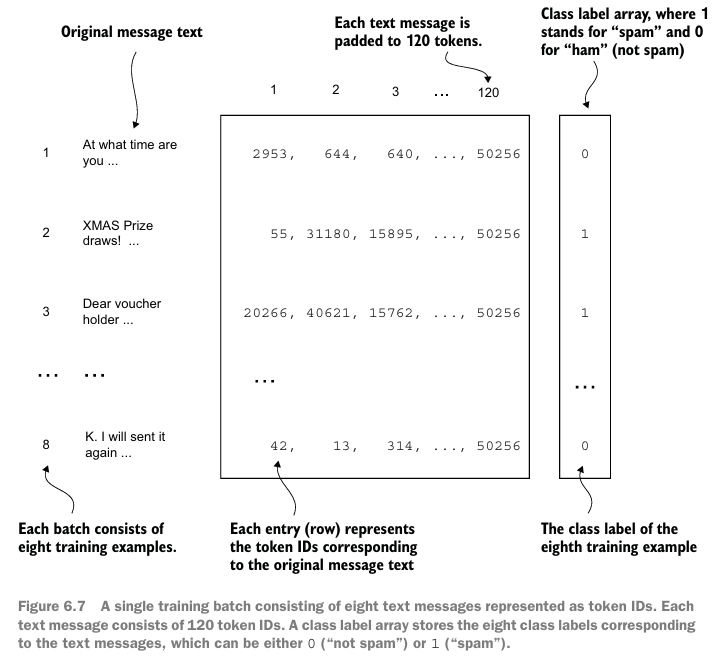

In [19]:
from torch.utils.data import DataLoader

Creamos los data loaders para cada set (training, validación y test), con batches de tamaño 8

In [20]:
num_workers = 0     
batch_size = 8
torch.manual_seed(123)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

Chequeemos que se inicializaron bien

In [22]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [23]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


### Inicializando el modelo con los pre-trained weights

In [24]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

In [25]:
BASE_CONFIG = {
    "vocab_size": 50257,         
    "context_length": 1024,      
    "drop_rate": 0.0,            
    "qkv_bias": True             
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [27]:
import import_ipynb

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBac

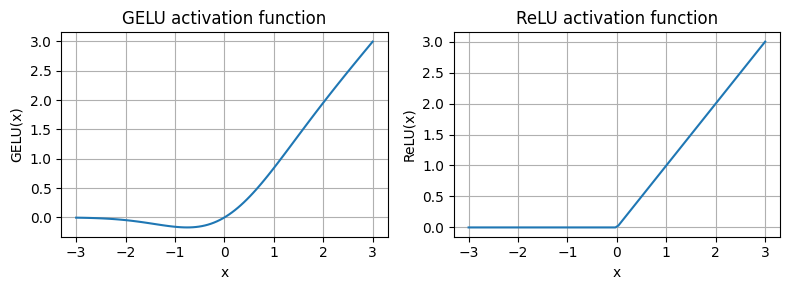

torch.Size([2, 3, 768])
layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606
layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472
Note: you may need to restart the kernel to use updated packages.
tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])
Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)
Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0

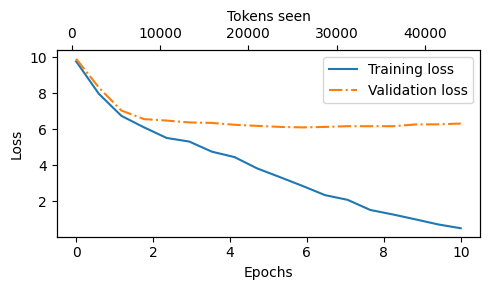

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"


forward
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


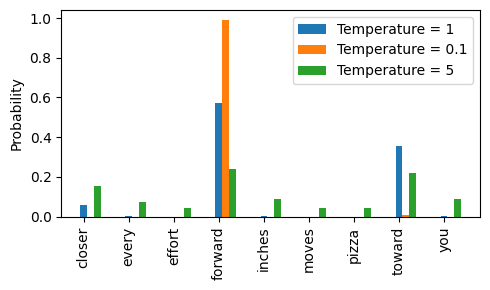

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])
tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])
Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


<string>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
<string>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which us

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [28]:
from gpt_download import download_and_load_gpt2
from ch5 import GPTModel, load_weights_into_gpt
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
model_size=model_size, models_dir="gpt2"
)
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

Chequeamos que lo que importamos esté bien (genera texto coherente)

In [29]:
from ch4 import generate_text_simple
from ch5 import text_to_token_ids, token_ids_to_text
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


Antes de finetunear para clasificación, veamos qué podemos hacer primero si prompteamos el modelo con instrucciones

In [30]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Tenemos que hacer classification finetuning


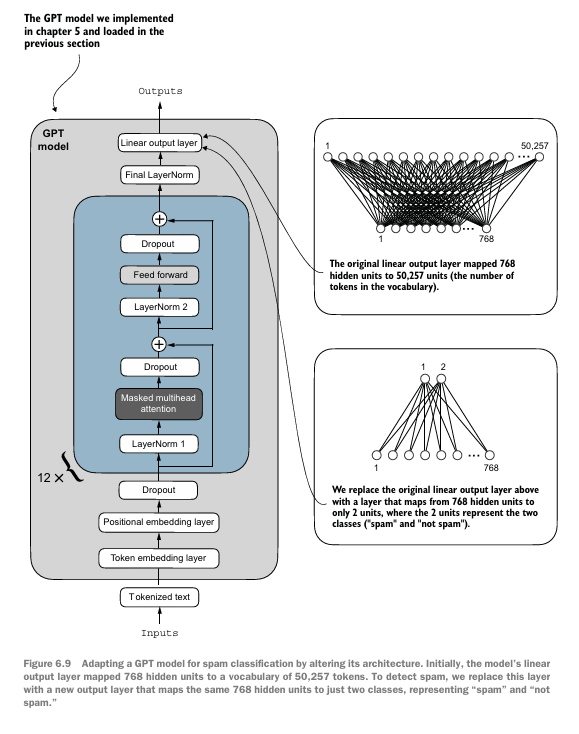

Antes de fine-tunear el modelo, tenemos que frizarlo; es decir, tenemos que hacer las capas non-trainable.

In [31]:
for param in model.parameters():
    param.requires_grad = False

Luego cambiamos la ultima capa (que originalmente iba a 50257 neuronas) a 2 (la cantidad de clases)

In [32]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], 
    out_features=num_classes
)

Esta ultima capa tiene requires_grad= True (y es la unica), por lo que solo se va a reentrenar esta última.

Igual, vamos a settear la ultima layernorm y el último transformer block para que sean entrenables también.

In [33]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

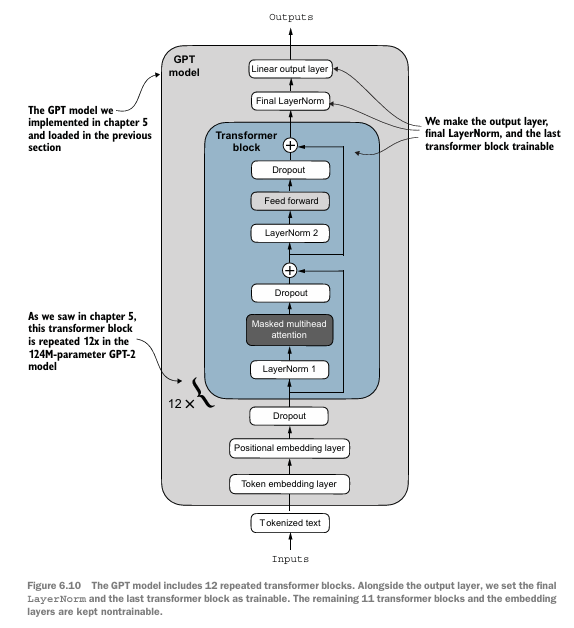

In [34]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


Lo siguiente es un ejemplo de la pasada forward del modelo con el input que generamos recién

In [35]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


Pero nos interesa solamente el último token

In [36]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


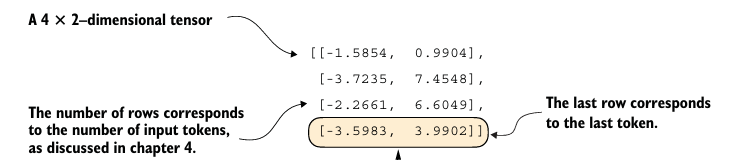

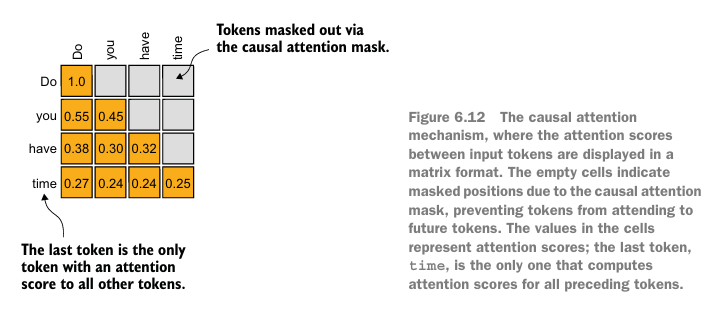

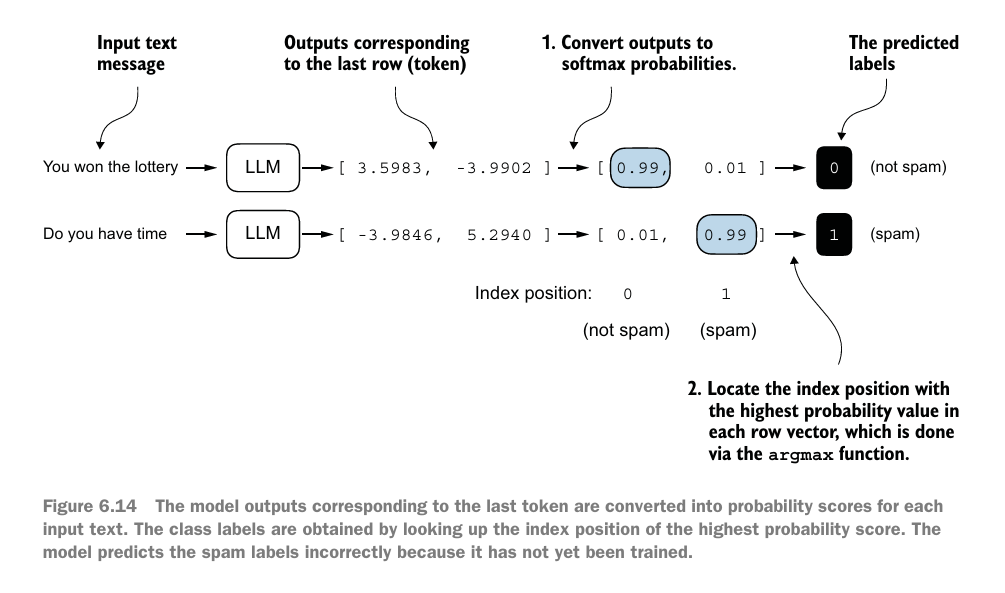

In [37]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


### Evaluando el modelo

In [39]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]    
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += ((predicted_labels == target_batch).sum().item())
        else:
            break
    return correct_predictions / num_examples

Usemos esta función para evaluar la accuracy en cada dataset, estimado a partir de 10 batches, para eficiencia.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Las accuracies dan malas porque todavía el modelo no fue fine-tuneado.

Incluso antes tenemos que definir la función que queremos optimizar: esta va a ser la cross-entropy loss, considerando siempre el ultimo token, ya que no nos van a interesar los outputs de los otros tokens (el ultimo token es el que usa toda la información de los otros)

In [41]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # logits del ultimo token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [42]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                       
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [43]:
with torch.no_grad():                
    train_loss = calc_loss_loader(
 train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


Ahora vamos a implementar una función de entrenamiento para minimizar la training set loss. Esto es ajustar los modelos con el dataset de training.

### Fine-tuneando el modelo con datos supervisados

In [44]:
def train_classifier_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []  
    examples_seen, global_step = 0, -1
    for epoch in range(num_epochs):   
        model.train() # sets the model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                     
            loss = calc_loss_batch(
            input_batch, target_batch, model, device
            )
            loss.backward()                         
            optimizer.step()                         
            examples_seen += input_batch.shape[0]   
            global_step += 1
        
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [45]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
 )
    val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
 )
    model.train()
    return train_loss, val_loss

In [ ]:
#esto tarda mucho

import time
start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = \
train_classifier_simple(
model, train_loader, val_loader, optimizer, device,
num_epochs=num_epochs, eval_freq=50,
eval_iter=5
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.699, Val loss 0.659
Ep 1 (Step 000050): Train loss 0.488, Val loss 0.541
Ep 1 (Step 000100): Train loss 0.369, Val loss 0.442
Training accuracy: 87.50% | Validation accuracy: 82.50%
Ep 2 (Step 000150): Train loss 0.658, Val loss 0.442


KeyboardInterrupt: 

Ploteamos los errores

In [ ]:
import matplotlib.pyplot as plt
def plot_values(
epochs_seen, examples_seen, train_values, val_values,
label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
 epochs_seen, val_values, linestyle="-.",
 label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)   
    ax2.set_xlabel("Examples seen")
    fig.tight_layout()            
    plt.savefig(f"{label}-plot.pdf")
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

Vemos accuracies para cada dataset

In [ ]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

### Usando el LLM como un spam classifier

In [ ]:
def classify_review(
 text, model, tokenizer, device, max_length=None,
 pad_token_id=50256):
    model.eval()
    input_ids = tokenizer.encode(text)         
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(             
    max_length, supported_context_length
    )]

    input_ids += [pad_token_id] * (max_length - len(input_ids))   
    input_tensor = torch.tensor(
 input_ids, device=device
    ).unsqueeze(0)
                 
    with torch.no_grad():                               
        logits = model(input_tensor)[:, -1, :]    
    predicted_label = torch.argmax(logits, dim=-1).item()
    return "spam" if predicted_label == 1 else "not spam"

Probemos con algunos ejemplos:

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)
print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

Guardamos el modelo para no entrenarlo de nuevo

In [ ]:
torch.save(model.state_dict(), "review_classifier.pth")

Una vez guardado, lo podemos cargar

In [ ]:
model_state_dict = torch.load("review_classifier.pth, map_location=device")
model.load_state_dict(model_state_dict)